In [344]:
#import JPype1
from konlpy.tag import Hannanum
from konlpy.utils import pprint
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from datetime import datetime, timedelta
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import requests
import urllib.request
import urllib.parse
from urllib.request import urlopen
from bs4 import BeautifulSoup
import os
os.chdir('F:/news/newss')
# ## 주가 읽기

In [411]:
def read_file():
    stock = pd.read_csv("sk하이닉스.csv")
    stock['date'] = pd.to_datetime(stock['date'], format ='%Y-%m-%d')
    for i in range(len(stock)):
        stock['per'][i]=(float(stock['per'][i].replace("%",""))/100)

    # # 뉴스 url읽기
    url = pd.read_csv("crawling_news2.txt", header = None, names = ['date','href'])
    url['per']= "A"
    return url, stock

In [412]:
url, stock = read_file()
print("read_file")

read_file


<ipython-input-411-91f608ca0a0c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['per'][i]=(float(stock['per'][i].replace("%",""))/100)


In [413]:
#전처리
def Pretreatment(url,stock):
    delet_num=[]
    today = pd.Timestamp.now()
    today = str(today)[:10]
    today = pd.to_datetime(today, format ='%Y-%m-%d')
    for i in range(len(url)):
        url['date'][i] = str(url['date'][i])[:8]
        url['date'][i] = pd.to_datetime(url['date'][i], format ='%y.%m.%d')
        url['date'][i] = pd.Timestamp(url['date'][i]).date()
        while url['date'][i] not in list(stock['date']):
            url['date'][i]=url['date'][i]+timedelta(days=1)
#         if url['date'][i] == today:
#             delet_num.append(i)
#             continue
        for j in range(len(stock)):
            if url['date'][i] == stock['date'][j]:
                url['per'][i] = stock['per'][j-1] #다음날 주가
#     url=np.delete(url, (delet_num), axis = 0)
    te4 = pd.DataFrame(url)
    te4 =te4.drop_duplicates(["date"])
    q1 = te4["per"].quantile(.25)
    q3 = te4["per"].quantile(.75)
    for i in range(len(url)):
        if url['per'][i] > q3:
            url['per'][i] = 0
        elif url['per'][i] <= q3 and url['per'][i]>0:
            url['per'][i] = 1
        elif url['per'][i] <= 0 and url['per'][i]>q1:
            url['per'][i] = 2
        else:
            url['per'][i] = 3
    return url

    # ### 퍼센트 원 핫 인코딩

    # ##### 원핫 인코딩 y값 제거해야 한다 함

    # from tensorflow.keras.utils import to_categorical
    # #float(te4["per"][1])
    # url['per'] = list(to_categorical(url['per']))
    #

In [414]:
url = Pretreatment(url,stock)
print("Pretreatment")

Pretreatment


In [415]:
#test와 train데이터 분리

# # 전처리 및 토큰화
def morpheme(data):
    news_group=[]
    j=0
    for i in range(len(data)):
        webpage = requests.get(data['href'][i])
        soup = BeautifulSoup(webpage.content, "html.parser")
        soup = soup.select_one('#newsViewArea').get_text()
        soup = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]', '', soup)
        if i == 0 :
            news_group_date = data['date'][i]
            news_group_content = soup
            count = 1
            news_group = pd.DataFrame([news_group_date,news_group_content,data['per'][i],count],['date','content','per','count']).transpose()
            continue
        if news_group['date'][j] == data['date'][i]:
            news_group['content'][j] = news_group['content'][j] + soup
            count + 1
            news_group['count'][j] = count
        else :
            j = j + 1
            count = 1
            a = {'date':data['date'][i],'content':soup,'per':data['per'][i],'count':count}
            news_group = news_group.append(a,ignore_index=True)
    return news_group

In [416]:
all_data=morpheme(url)
print("morpheme")


morpheme


In [417]:
all_data=all_data.drop_duplicates(['content'], keep = 'first')
all_data.reset_index()
all_data.to_csv('all_data.csv')

In [488]:
all_data = pd.read_csv('all_data.csv')

In [497]:
all_data

,Unnamed: 0,date,content,per,count
0,0,2021-05-17,삼성전자의 국내 직원 수가 만명을 돌파하며 역대 최대치를 기록했다일 삼성전자는 분기...,0,1
1,1,2021-05-16,올해 개인투자자가 유가증권시장에서 조원 넘게 순매수한 것으로 집계됐다 이는 지난해...,3,1
2,2,2021-05-14,삼성바이오로직스 주가가 일 사상 최고가를 기록하며 시가총액에서도 위에 올라섰다 미...,2,1
3,3,2021-04-06,미국 대표 메모리반도체 업체 마이크론이 분기월 결산법인으로 년 월년 월에 해당 호실...,1,1
4,4,2021-04-05,공매도 재개 시점이 한 달 앞으로 다가오면서 동학개미들이 좌불안석이다 오는 월 일...,2,1
...,...,...,...,...,...
252,252,2012-04-05,일본의 도시바가 googletagdisplaygoogledfpMCx 한국의 SK 하...,3,1
253,253,2012-04-04,금융감독원이 금융권에서 빚이 많은 개 대기업 그룹을 주채무계열로 선정했습니다 선...,0,1
254,254,2012-04-02,주식투자를 위해 가장 중요한 것은 투자 승률과 수익률입니다주식투자로 돈을 버는 주식...,0,1
255,255,2012-03-30,SK하이닉스가 세계 위의 D램업체인 일본의 엘피다 인수를 추진합니다 SK하이닉스...,1,1


In [493]:
print(all_data['count'])

0      1
1      1
2      1
3      1
4      1
      ..
252    1
253    1
254    1
255    1
259    1
Name: count, Length: 257, dtype: int64


In [494]:
def text_except_all(data):
    tokken = []
    tok=[]
    hannanum=Hannanum()
    for i in range(len(data)):
        tokken.append(hannanum.pos(data['content'][i]))

    # ### 토큰 중 가장 긴 토큰을 기준으로 반복 및 형태소 중 명사 동사 선택

    lenA = []
    for i in range(len(tokken)):
        lenA.append(len(tokken[i]))
    max(lenA)

    
    Stopword = pd.read_csv("한국어불용어100.txt", header=None, names=['text','x','num'],delimiter = '\t')
    for i in range(len(tokken)):
        all_tokken=[]
        for j in range(lenA[i]):
            if tokken[i][j][1] == 'N' and tokken[i][j][0] not in Stopword['text'].values:
                all_tokken.append(tokken[i][j][0])
        tok.append(all_tokken)
    return tok

In [498]:
all_data=all_data.reset_index()
all_data['content'] = text_except_all(all_data)
# print("text_except")

In [499]:
all_data

,index,Unnamed: 0,date,content,per,count
0,0,0,2021-05-17,"[삼성전자, 국내, 직원, 만명, 돌파, 역대, 최대치, 기록했다, 삼성전자, 분기...",0,1
1,1,1,2021-05-16,"[올해, 개인투자자, 유가증권시장, 조원, 순매수한, 집계, 지난해, 전체, 기간,...",3,1
2,2,2,2021-05-14,"[삼성바이오로직스, 주가, 사상, 최고가, 기록, 시가총액, 위, 미국, 모더나, ...",2,1
3,3,3,2021-04-06,"[미국, 대표, 메모리반도체, 업체, 마이크론, 분기월, 결산법인, 월년, 해당, ...",1,1
4,4,4,2021-04-05,"[공매, 재개, 시점, 달, 동학개미들, 좌불안석이다, 삼성전자, 비롯, 대형주, ...",2,1
...,...,...,...,...,...,...
252,252,252,2012-04-05,"[일본, 도시바, 한국의, 하이닉스반도체, 엘피다메모리, 공동, 제안, 니혼게이자이...",3,1
253,253,253,2012-04-04,"[금융감독원, 금융권, 빚, 대기업, 그룹, 주채무계열, 선정, 선정, 대상, 금융...",0,1
254,254,254,2012-04-02,"[주식투자, 중요, 투, 승률, 수익률입니다주식투자, 돈, 주식투자자, 의, 비법,...",0,1
255,255,255,2012-03-30,"[SK하이닉스, 세계, 위, D램업체, 일본, 엘피다, 추진, SK하이닉스, 거래소...",1,1


In [500]:
all_data.to_csv('all_data_tokken.csv')

In [734]:
all_data = pd.read_csv('all_data_tokken.csv')

In [735]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data['content'])

vocab_size = 1000  # 상위 500 단어만 사용
tokenizer = Tokenizer(num_words = vocab_size + 1)
tokenizer.fit_on_texts(all_data['content'])

# print(tokenizer.word_index) #인덱스가 어떻게 부여됬는지(입력된 단어 순서)
# print(tokenizer.word_counts) #상위 몇개 단어를 했을 때 어떻게 부여됬는지(입력된 단어 순서)

def text_size(num):
    threshold = num
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

    #단어수가 2개인 단어의 빈도가 6.1%라 유의미한 영향을 줄 수 있어 제외하지 않는다

    # 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
    # 0번 패딩 토큰을 고려하여 + 1
    vocab_size = total_cnt - rare_cnt + 1
    print('단어 집합의 크기 :',vocab_size)


    # ## 앞의 형태소분석을 붙여씀
    # ### 불필요하게 주가를 넣는 부분이 있고 href에서 본문을 따오는 부분 함수화 고려

text_size(2)

단어 집합(vocabulary)의 크기 : 16237
등장 빈도가 1번 이하인 희귀 단어의 수: 9316
단어 집합에서 희귀 단어의 비율: 57.37513087392991
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.103370974997904
단어 집합의 크기 : 6922


In [736]:
from sklearn.cluster import KMeans
clustering = tokenizer.texts_to_sequences(all_data['content'])
clustering = pad_sequences(clustering, maxlen = 500)
# 군집화 할 그룹의 갯수 정의
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters).fit(clustering)

# trained labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# labels에 merge
all_data['labels'] = labels

In [737]:
def train_test(data):
    train, test = train_test_split(data, test_size= 0.2, random_state=1234)

    #인덱스 초기화
    train = train.reset_index()
    test = test.reset_index()
    return train, test

train, test = train_test(all_data)
print("train_test")

train_test


In [738]:
# train_data = morpheme(train)
# test_data = morpheme(test)

# train_data['content'] = text_except(train_data['content'])
# test_data['content'] = text_except(test_data['content'])

# X_train = train['content']
# X_test = test['content']
X_train = tokenizer.texts_to_sequences(train['content'])
X_test = tokenizer.texts_to_sequences(test['content'])

y_train = train['per']
y_train = pd.DataFrame(y_train)
y_test = test['per']
y_test = pd.DataFrame(y_test)


drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
# X_train = np.delete(X_train, drop_train, axis=0)
# y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

205
205


뉴스의 최대 길이 : 12
뉴스의 평균 길이 : 0.06779661016949153


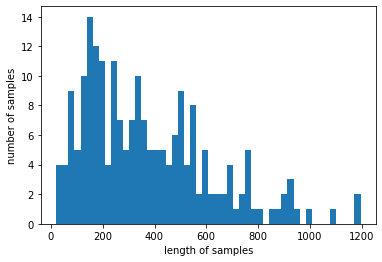

In [739]:
# ## 패딩

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


print('뉴스의 최대 길이 :',max(len(l) for l in all_data))
print('뉴스의 평균 길이 :',sum(map(len, all_data))/len(url))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [740]:
max_len = 1200
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 1200 이하인 샘플의 비율: 100.0


In [741]:
td

,date
0,2020-02-18
1,2020-02-19
2,2017-06-08
3,2015-10-07
4,2019-05-28
...,...
200,2017-12-26
201,2015-02-04
202,2019-11-11
203,2020-04-16


In [742]:

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)



X_train2 = pd.DataFrame(X_train)
X_train2=X_train2.astype('float64')
X_test2 = pd.DataFrame(X_test)
X_test2=X_test2.astype('float64')



y_train=y_train.astype('float64')
y_test=y_test.astype('float64')

#------------------3D DataFrame--------------------bidirectional
# threeD_X_train2 = pd.DataFrame(date = train['date'],content = X_train2,rabels = train['labels'])
td = pd.DataFrame(train['date'])
la = pd.DataFrame(train['labels'].astype(np.float64))
# se = pd.Series(X_train)
# X_train3 = pd.DataFrame({'content':X_train.values})
threeD_X_train2 = pd.concat([X_train2,la],ignore_index=True,axis=1)
threeD_X_train2=threeD_X_train2.astype(np.float64)
threeD_X_train2 = np.array(threeD_X_train2).reshape(threeD_X_train2.shape[0], threeD_X_train2.shape[1], 1)
# ,'date','content','labels'.transpose()

#----------------------------------------

# X_train2 = np.array(X_train2).reshape(X_train2.shape[0], X_train2.shape[1], 1)
# y_train = np.array(y_train).reshape(y_train.shape[0], y_train.shape[1], 1)
# X_test2 = np.array(X_test2).reshape(X_test2.shape[0], X_test2.shape[1], 1)
# y_test = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1], 1)


# #### loss = sparse_categorical_crossentropy은 y값을 원핫인코딩하지 않는다
# y_train = to_categorical(y_train, 4)

In [743]:
X_train

array([[ 0,  0,  0, ..., 22, 23, 40],
       [ 0,  0,  0, ..., 22, 23, 40],
       [ 0,  0,  0, ..., 22, 23, 40],
       ...,
       [ 0,  0,  0, ..., 22, 23, 40],
       [ 0,  0,  0, ..., 22, 23, 40],
       [ 0,  0,  0, ..., 22, 23, 40]])

In [744]:
threeD_X_train2.shape[0]

205

In [745]:
X_train2

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,5.0,856.0,19.0,413.0,826.0,17.0,22.0,23.0,40.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,5.0,60.0,10.0,375.0,350.0,17.0,22.0,23.0,40.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,5.0,60.0,10.0,375.0,350.0,17.0,22.0,23.0,40.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,834.0,6.0,101.0,188.0,538.0,17.0,22.0,23.0,40.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,191.0,224.0,504.0,111.0,921.0,726.0,758.0,895.0,45.0,666.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,8.0,5.0,665.0,442.0,17.0,22.0,23.0,40.0
201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,36.0,430.0,5.0,19.0,188.0,17.0,22.0,23.0,40.0
202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,5.0,62.0,10.0,375.0,666.0,17.0,22.0,23.0,40.0
203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,5.0,62.0,10.0,375.0,666.0,17.0,22.0,23.0,40.0


In [746]:
threeD_X_train2.fillna(value='', inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [747]:
type(threeD_X_train2[4][2])

numpy.ndarray

In [748]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [749]:
model = Sequential()
#model.add(Embedding(vocab_size, 100)) #모델에 입력크기를 고정된 크기고 제한
#model.add(Dense(2, activation='softmax'))
model.add(Bidirectional(LSTM(128, input_shape = (len(threeD_X_train2),1))))
# model.add(LSTM(128, batch_input_shape = (270,1,1), stateful = True))#,stateful=True
#,return_sequences=True, input_shape = (300,1) 입력형식, stateful=True 상태유지
model.add(Dropout(0.2, input_shape=(270,1)))
initializer = tf.keras.initializers.HeNormal() #가중치 초기화
model.add(Dense(90, activation='relu',kernel_initializer=initializer))

model.add(Dense(90, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#patience loss가 갑소해도 20번은 더해라
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc','sparse_categorical_accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc','sparse_categorical_accuracy'])
#history = model.fit(X_train2, y_train, epochs=100, callbacks=[es, mc], batch_size=20, validation_split=0.2)
history = model.fit(threeD_X_train2, y_train, epochs=1000, callbacks=[es, mc], batch_size=20, validation_split=0.2)
#validation_split 전체데이터(train)중 얼마를 학습할 것이냐
#batch_size 계산 후 가중치를 넘길 계산 단위

Epoch 1/1000
9/9 [==============================] - 12s 898ms/step - loss: 1.3922 - acc: 0.2881 - sparse_categorical_accuracy: 0.2881 - val_loss: 1.4251 - val_acc: 0.2439 - val_sparse_categorical_accuracy: 0.2439

Epoch 00001: val_acc improved from -inf to 0.24390, saving model to best_model.h5
Epoch 2/1000
9/9 [==============================] - 7s 793ms/step - loss: 1.3895 - acc: 0.2956 - sparse_categorical_accuracy: 0.2956 - val_loss: 1.4102 - val_acc: 0.2195 - val_sparse_categorical_accuracy: 0.2195

Epoch 00002: val_acc did not improve from 0.24390
Epoch 3/1000
9/9 [==============================] - 7s 768ms/step - loss: 1.3875 - acc: 0.2926 - sparse_categorical_accuracy: 0.2926 - val_loss: 1.4134 - val_acc: 0.2439 - val_sparse_categorical_accuracy: 0.2439

Epoch 00003: val_acc did not improve from 0.24390
Epoch 4/1000
9/9 [==============================] - 7s 788ms/step - loss: 1.3784 - acc: 0.3119 - sparse_categorical_accuracy: 0.3119 - val_loss: 1.4136 - val_acc: 0.2439 - val_sp

In [726]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test2, y_test)[1]))

# 학습 결과 그래프 그리기

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['sparse_categorical_accuracy'], 'g', label='train acc')
acc_ax.plot(history.history['val_sparse_categorical_accuracy'], 'b', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

# # 끝

ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_81 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1200)


# 상태유지 스택 순환신경망

In [243]:
def train_test(data, per):
    train, test = train_test_split(data, test_size= per, random_state=1234)

    #인덱스 초기화
    train = train.reset_index()
    test = test.reset_index()
    return train, test

train, test = train_test(all_data,0.2)
print("train_test")

train_test


In [253]:
X_train = tokenizer.texts_to_sequences(train['content'])
X_test = tokenizer.texts_to_sequences(test['content'])

y_train = train['per']
y_train = pd.DataFrame(y_train)
y_test = test['per']
y_test = pd.DataFrame(y_test)

In [254]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)



X_train2 = pd.DataFrame(X_train)
X_train2=X_train2.astype('float64')
X_test2 = pd.DataFrame(X_test)
X_test2=X_test2.astype('float64')



y_train=y_train.astype('float64')
y_test=y_test.astype('float64')



X_train2 = np.array(X_train2).reshape(X_train2.shape[0], X_train2.shape[1], 1)
X_test2 = np.array(X_test2).reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_train = np.array(y_train).reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1], 1)


In [278]:

X_train2=np.delete(X_train2, (0,1,2,3,4,5,6,7,8,9), axis = 0)
X_test2.shape

(33, 800, 1)

In [275]:
model = Sequential()
model.add(LSTM(128, batch_input_shape = (24,X_train2.shape[1], 1), stateful = True))#,stateful=True
# model.add(LSTM(128, batch_input_shape = (X_train2.shape[1],X_train2.shape[0],1), stateful = True))
# model.add(Dropout(0.2, input_shape=(270,1)))

#initializer = tf.keras.initializers.HeNormal() #가중치 초기화
# model.add(Dense(90, activation='relu',kernel_initializer=initializer))
model.add(Dense(90, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [276]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#patience loss가 갑소해도 20번은 더해라
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc','categorical_accuracy'])
#history = model.fit(X_train2, y_train, epochs=100, callbacks=[es, mc], batch_size=20, validation_split=0.2)
history = model.fit(X_train2, y_train, epochs=1000, batch_size=24, validation_split=0.2,callbacks=[es, mc])
#validation_split 전체데이터(train)중 얼마를 학습할 것이냐
#batch_size 계산 후 가중치를 넘길 계산 단위

Epoch 1/1000
4/4 [==============================] - 4s 697ms/step - loss: 1.3911 - acc: 0.1806 - categorical_accuracy: 0.5333 - val_loss: 1.2405 - val_acc: 0.3333 - val_categorical_accuracy: 1.0000

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to best_model.h5
Epoch 2/1000
4/4 [==============================] - 2s 385ms/step - loss: 1.2450 - acc: 0.3417 - categorical_accuracy: 0.5722 - val_loss: 1.1817 - val_acc: 0.3333 - val_categorical_accuracy: 1.0000

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/1000
4/4 [==============================] - 2s 407ms/step - loss: 1.1931 - acc: 0.3069 - categorical_accuracy: 0.6986 - val_loss: 1.1654 - val_acc: 0.3333 - val_categorical_accuracy: 1.0000

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/1000
4/4 [==============================] - 2s 390ms/step - loss: 1.1722 - acc: 0.4431 - categorical_accuracy: 1.0000 - val_loss: 1.1714 - val_acc: 0.3333 - val_categorical_accuracy: 1.0000

Epoch 00004: val_acc d

In [277]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test2, y_test)[1]))

# 학습 결과 그래프 그리기

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['sparse_categorical_accuracy'], 'g', label='train acc')
acc_ax.plot(history.history['val_sparse_categorical_accuracy'], 'b', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

# # 끝

InvalidArgumentError:    Specified a list with shape [24,1] from a tensor with shape [32,1]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_67/lstm_67/PartitionedCall]] [Op:__inference_test_function_203588]

Function call stack:
test_function -> test_function -> test_function


# 텐서보드

In [33]:
# tb_hist = keras.callbacks.TensorBoard(log_dir='.\graph', histogram_freq=0, write_graph=True, write_images=True)
# model.fit(X_train2, y_train, epochs=100, callbacks=[es, mc,tb_hist], batch_size=60, validation_split=0.2)
# 순환신경망은 fit가 여러번 일어나 제대로 학습상태를 알 수 없다

SyntaxError: keyword argument repeated (<ipython-input-33-134858f07bc8>, line 2)

In [ ]:
#텐서보드 실행을 위해 콘솔에서 텐서보드를 띄운다
#tensorboard --logdir=~/projects/Keras/_writing/graph

In [45]:
class Customhistory( keras.callbacks.Callback):
    def init(self):
        self.train_loss=[]
        self.val_loss=[]
        self.train_acc=[]
        self.val_acc=[]
        
    def on_epoch_end(self, batch, log={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [ ]:
customhist = Customhistory()
for epoch_idx in range(150):
    print('epochs : ' + str(epoch_idx))
    model.fit(X_train2, y_train, callbacks=[mc,tb_hist], batch_size=60, validation_split=0.2)
